In [224]:
#visualisasi
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

#preprosessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from collections import Counter
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#encoder
from sklearn.preprocessing import LabelEncoder

#split data
from sklearn.model_selection import train_test_split

#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#pilih model
from lazypredict.Supervised import LazyClassifier

#evaluation model
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report    
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RanggaSaputra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [197]:
data_path = './data/'

## Fungsi dalam code ini

In [198]:
# Fungsi untuk hitung huruf
def count_word(text):
    #split teks menjadi kata-kata
    words = text.split()

    #hitung frekuensi masing-masing kata
    word_freq = Counter(words)

    #membuat dataFrame dari frekuensi kata
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Kata', 'Frekuensi'])

    #menyusun frekuensi kata tertinggi
    word_freq_df = word_freq_df.sort_values(by='Frekuensi', ascending=False)

    return word_freq_df

In [199]:
# Fungsi untuk preprosessing
def clear_word(caption):
    # Casefolding
    caption = caption.lower()
    
    # Remove angka
    caption = re.sub('[0-9]+', '', str(caption))

    # Remove hyperlinks
    caption = re.sub(r'https?:\/\/\S+', '', str(caption))

    # Remove hashtags
    caption = re.sub(r'#[A-Za-z0-9_]+', '', str(caption))

    # Remove symbol
    caption = re.sub(r'[^\x00-\x7f]', '', str(caption))
    
    # Remove mention and link
    caption = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", caption)

    # Remove comma
    caption = re.sub(r',',' ', str(caption))

    # Remove double huruf
    caption = re.sub(r'(\w)\1+', r'\1', caption)

    # Remove punctuation
    caption = re.sub(r'[^\w\s]', '', str(caption))

    # Remove newline
    caption = re.sub(r'\n', '', str(caption))

    # Remove spasi ganda
    caption = re.sub(r'\s+', ' ', str(caption))

    return caption

In [200]:
# hapus baris yang hanya ada 1 baris
def remove_sentence(caption): 
        word = caption.split()
        wordCount = len(word)
        if(wordCount<=1):
            caption = ''

        return caption

In [201]:
import json

slangword = {}

with open(data_path+'combined_slang_words.txt', 'r') as f:
    slangword = json.load(f)

#buat slangword
def replace_slang_words(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    new_words = []
    for word in words:
        if word in slangword:
            new_words.append(slangword[word])
        else:
            new_words.append(word)
    new_text = ' '.join(new_words)
    return new_text

In [202]:
kata_tambahan = ["pak", "bapak", "aku", "p"]

In [203]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def remove_stopwords(caption):
    return ' '.join([word for word in caption.split() if word not in kata_tambahan])

## cek data

In [204]:
#import pandas
import pandas as pd

#load data
df_tweet = pd.read_csv(data_path+'tweet.csv')
df_tweet.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [205]:
df_tweet = df_tweet.drop(columns=["Unnamed: 0"])
df_tweet.head()


,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [206]:
#cek null
df_tweet.isnull().sum()

sentimen    0
tweet       0
dtype: int64

## Wordcloud sebelum preprosessing

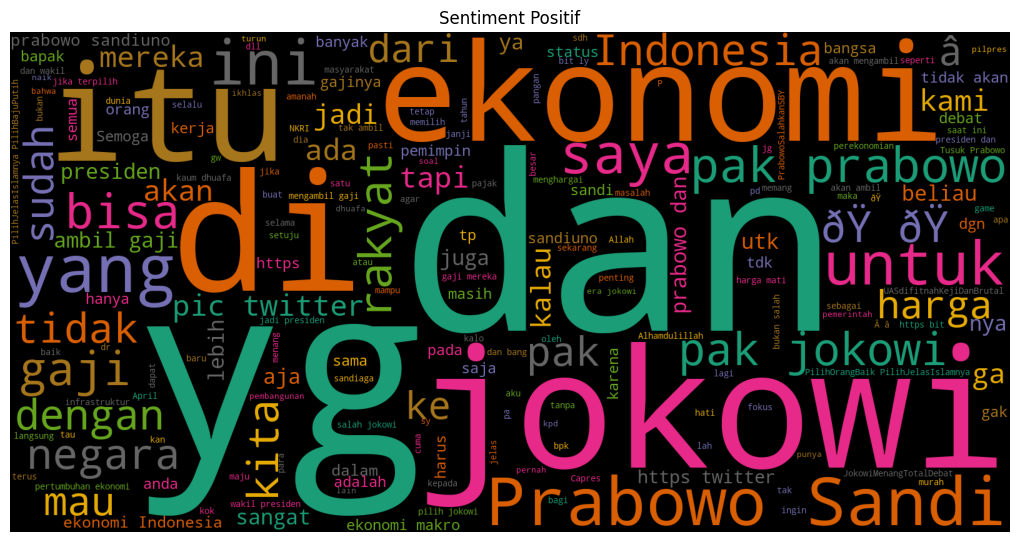

In [207]:
#worldcloud positif
data_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
word_positif = pd.Series(' '.join(data_positif['tweet']).split())
text_posi = ' '.join(word_positif)

# Display the generated image:
wordcloud_posi = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(wordcloud_posi)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [208]:
#cek frekuesin kata
freq_posi = count_word(text_posi)
freq_posi.head(15)

,Kata,Frekuensi
115,dan,330
43,yg,239
7,ekonomi,209
31,di,175
69,akan,142
83,yang,125
78,gaji,113
15,Jokowi,113
486,pak,110
42,itu,106


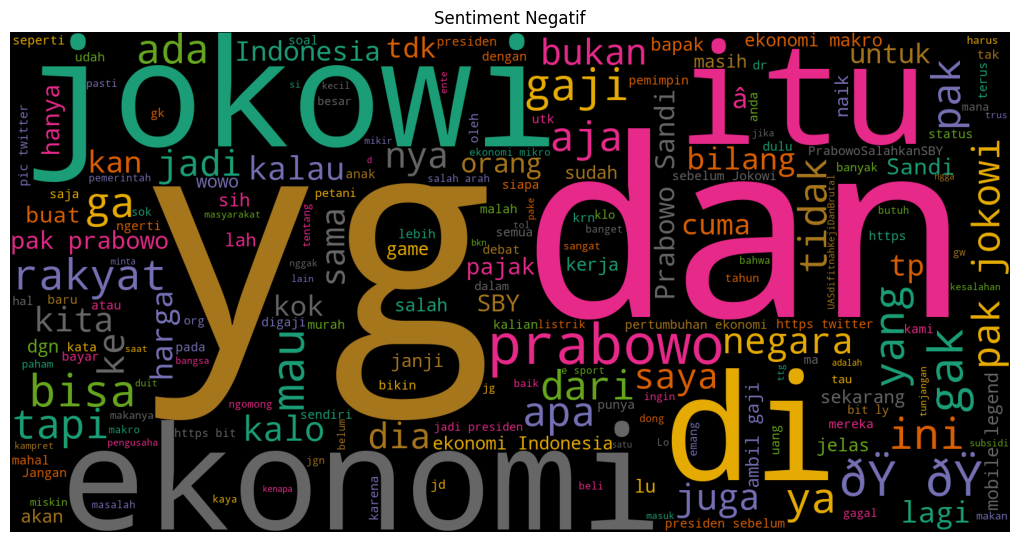

In [209]:
#worldcloud negatif
data_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
word_negatif = pd.Series(' '.join(data_negatif['tweet']).split())
text_neg = ' '.join(word_negatif)

# Display the generated image:
wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_neg)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [210]:
#cek frekuesin kata
freq_nega = count_word(text_neg)
freq_nega.head(15)

,Kata,Frekuensi
99,yg,261
72,ekonomi,253
62,dan,166
163,di,165
36,itu,118
183,pak,100
233,Prabowo,88
38,bisa,87
66,gak,86
186,gaji,80


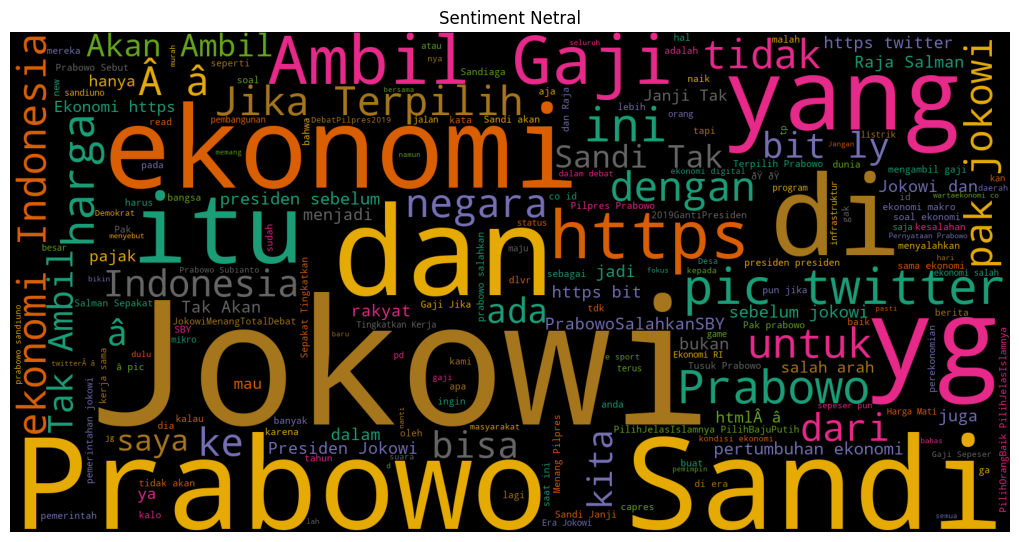

In [211]:
#worldcloud netral
data_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
word_netral = pd.Series(' '.join(data_netral['tweet']).split())
text_net = ' '.join(word_netral)

# Display the generated image:
wordcloud_netral = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_net)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(wordcloud_netral)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [212]:
#cek frekuesin kata
freq_net = count_word(text_net)
freq_net.head(15)

,Kata,Frekuensi
183,â€¦,192
14,ekonomi,192
216,dan,187
3,Jokowi,153
30,di,151
432,Prabowo,143
48,yg,121
222,Ekonomi,105
420,yang,91
15,Indonesia,74


## Preprosessing

In [213]:
df_tweet['tweet_clean'] = df_tweet['tweet'].apply(lambda x:replace_slang_words(x))
df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata @prabowo indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","batuan langka, tasbih jokowi hadiah dari habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","di era jokowi, ekonomi indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","bagi sumatera selatan, asian games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara kita hutang buat bangun infrastruktur y...


In [214]:
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x:clear_word(x))
df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia tidak dihargai bangsa asing ber...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah dari habib ...
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",di era jokowi ekonomi indonesia semakin baik p...
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",bagi sumatera selatan asian games berdampak pa...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara kita hutang buat bangun infrastruktur y...


In [215]:
#stopword
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x: " ".join(stopword.remove(x) for x in x.split() ))
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x: remove_stopwords(x))

df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia dihargai bangsa asing berita is...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia semakin baik pict...
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak ekonomi...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara hutang buat bangun infrastruktur dipake...


## Wordcloud setelah preprosessing

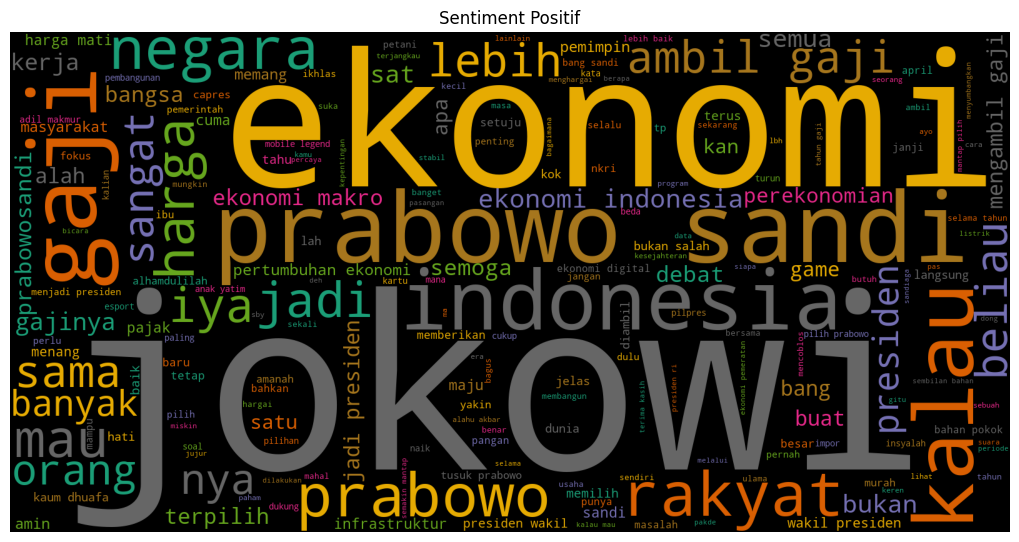

In [216]:
#worldcloud positif
data_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
word_positif = pd.Series(' '.join(data_positif['tweet_clean']).split())
text_posi = ' '.join(word_positif)

# Display the generated image:
wordcloud_posi = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(wordcloud_posi)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

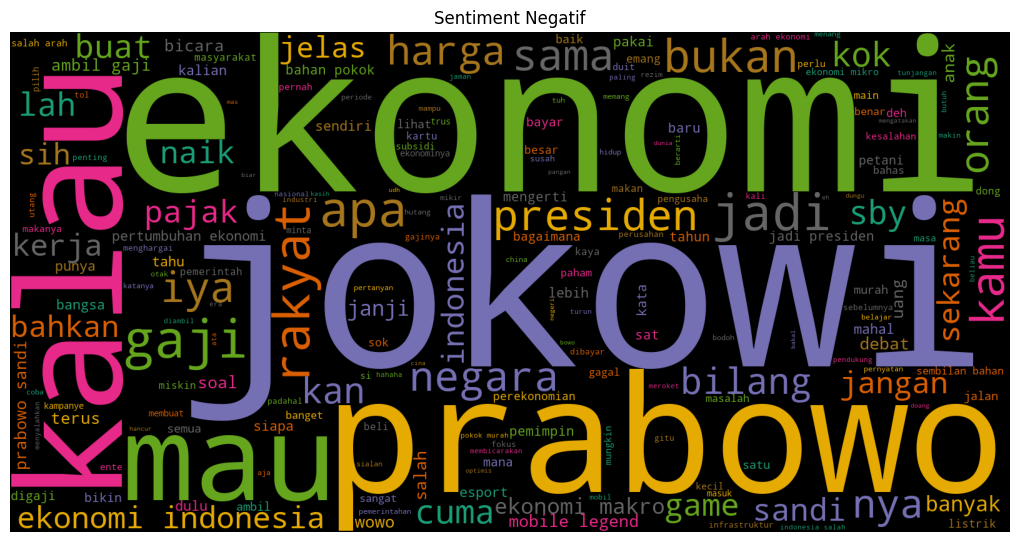

In [217]:
#worldcloud negatif
data_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
word_negatif = pd.Series(' '.join(data_negatif['tweet_clean']).split())
text_neg = ' '.join(word_negatif)

# Display the generated image:
wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_neg)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

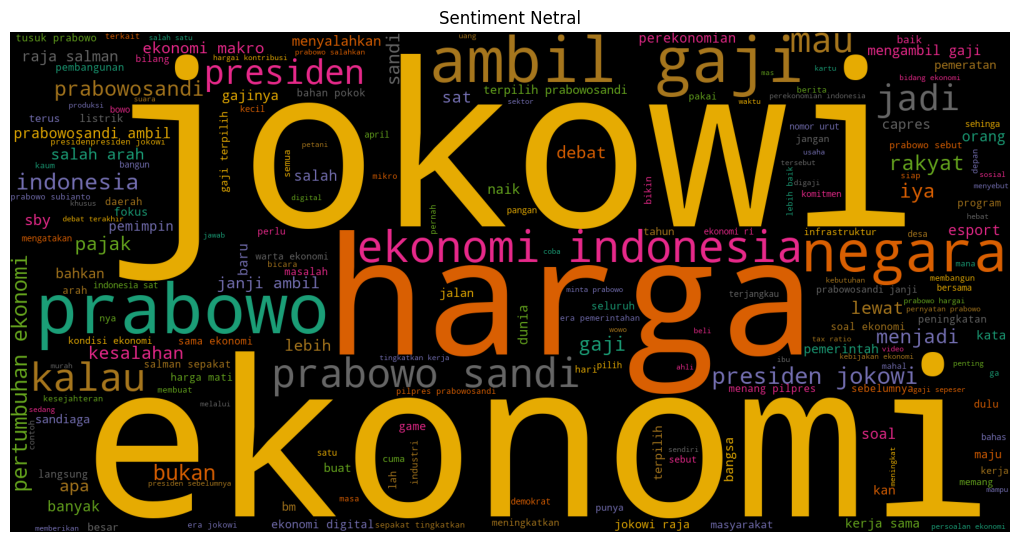

In [218]:
#worldcloud netral
data_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
word_netral = pd.Series(' '.join(data_netral['tweet_clean']).split())
text_net = ' '.join(word_netral)

# Display the generated image:
wordcloud_netral = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_net)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(wordcloud_netral)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## persiapan build model

In [220]:
# pisahkan antara label dan fitur 
y = df_tweet['sentimen']
X = df_tweet['tweet_clean']

In [221]:
# pembobotan menggunakan tf-idf 
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X)

# tranformasi teks ke tf-idf fitur
tfidf_matrix = vectorizer.transform(X)

# menubah dalam bentuk array
X_tdif = tfidf_matrix.toarray()

In [222]:
# encoding label 
enc = LabelEncoder() 
enc.fit(y.values)
y_enc=enc.transform(y.values)

In [223]:
# pisahkan train dan test
X_train_words, X_test_words, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=10)

X_train = vectorizer.transform(X_train_words)
X_train = X_train.toarray()

X_test = vectorizer.transform(X_test_words)
X_test = X_test.toarray()

In [226]:
# Inisialisasi LazyClassifier
clf = LazyClassifier(predictions=True)

# Lakukan klasifikasi
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [42:43<00:00, 88.38s/it]  


In [230]:
models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.62,0.60,None,0.61,37.42
RandomForestClassifier,0.60,0.59,None,0.60,18.72
Perceptron,0.58,0.56,None,0.57,5.64
LogisticRegression,0.56,0.55,None,0.55,16.54
XGBClassifier,0.55,0.55,None,0.55,166.27
LinearSVC,0.55,0.54,None,0.55,288.93
PassiveAggressiveClassifier,0.55,0.54,None,0.55,12.23
RidgeClassifierCV,0.55,0.54,None,0.54,5.92
RidgeClassifier,0.54,0.53,None,0.54,4.54
